In [10]:
import MySQLdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('../')
import myenvvar
from sklearn.cluster import DBSCAN
import datetime as dt
from sklearn.neighbors import NearestNeighbors

In [2]:
conn = MySQLdb.Connection(
        host=myenvvar.db_vars['host'],
        user=myenvvar.db_vars['user'],
        passwd=myenvvar.db_vars['password'],
        port=myenvvar.db_vars['port'],
        db=myenvvar.db_vars['db']
        )

In [3]:
conn.set_character_set('utf8')

In [4]:
def get_tracks_features_per_clustering_date_df(clustering_datetime):
    q = "select * from audio_features af where af.added_datetime <" +"'"+ str(clustering_datetime) + "'" # selects the exact tracks that were clustered at this date
    tracks_features_per_clustering_date_df = pd.read_sql(q, conn)
    cols_to_drop = ['key', 'time_signature', 'total_available_markets', 'mode', 'duration_ms','popularity','added_datetime']
    tracks_features_per_clustering_date_df = tracks_features_per_clustering_date_df.drop(cols_to_drop, axis=1)
    tracks_features_per_clustering_date_df.set_index('track_id',inplace=True)
    # normalyze / scale features
    for col in ['loudness', 'tempo']:
        tracks_features_per_clustering_date_df[col] = ((tracks_features_per_clustering_date_df[col] - tracks_features_per_clustering_date_df[col].min()) / (tracks_features_per_clustering_date_df[col].max() - tracks_features_per_clustering_date_df[col].min()))
    return tracks_features_per_clustering_date_df

In [5]:
q = "SELECT * FROM kmeans_clustering_params"
kmeans_clustering_params_df = pd.read_sql(q, conn)

In [6]:
kmeans_clustering_params_df.head()

,clustering_datetime,random_state,k,interia_score
0,2020-06-08 07:39:06,3,4,278.98907
1,2020-06-08 10:15:39,3,4,296.64117
2,2020-06-10 08:10:00,3,4,327.25442
3,2020-06-12 09:53:38,3,5,338.20297


In [7]:
tracks_features_per_clustering_date_df = get_tracks_features_per_clustering_date_df(kmeans_clustering_params_df['clustering_datetime'][3])

In [8]:
tracks_features_per_clustering_date_df.shape

(2100, 9)

In [9]:
tracks_features_per_clustering_date_df.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
track_id,,,,,,,,,
00bOhb4584JjyfTiXX81mO,0.629,0.387,0.482140,0.0386,0.42400,0.0000,0.0479,0.497,0.219707
00FldKRY0RvsKorwsMzNt3,0.605,0.856,0.739271,0.0666,0.03460,0.8730,0.0874,0.215,0.631622
00HqKJWFv3GS9cPfEB1WQm,0.678,0.795,0.731971,0.1310,0.01010,0.0159,0.0981,0.648,0.447355
00KCwnrvIXX8GRU3ZMOIBW,0.825,0.692,0.739610,0.0627,0.17200,0.0010,0.0861,0.602,0.479760
00VpefDueq3OB9zkZHLDVI,0.636,0.963,0.698017,0.0636,0.00342,0.1940,0.1130,0.766,0.485104


# find the optimal epsilon for DBSCAN 

In [36]:
neigh = NearestNeighbors(n_neighbors=2,metric='euclidean')

In [37]:
nbrs = neigh.fit(tracks_features_per_clustering_date_df)

In [38]:
nbrs

NearestNeighbors(algorithm='auto', leaf_size=30, metric='euclidean',
                 metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                 radius=1.0)

In [42]:
distances, indices = nbrs.kneighbors(tracks_features_per_clustering_date_df)

In [64]:
indices

array([[   0, 1877],
       [   1, 1511],
       [   2,  347],
       ...,
       [2097,  739],
       [2098,  365],
       [2099,  925]], dtype=int64)

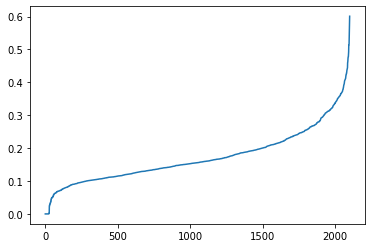

In [43]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [59]:
m = DBSCAN(eps=0.33, min_samples=10)
m.fit(tracks_features_per_clustering_date_df)

DBSCAN(algorithm='auto', eps=0.33, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=10, n_jobs=None, p=None)

In [60]:
clusters = m.labels_

In [61]:
tracks_features_per_clustering_date_df['cluster'] = clusters

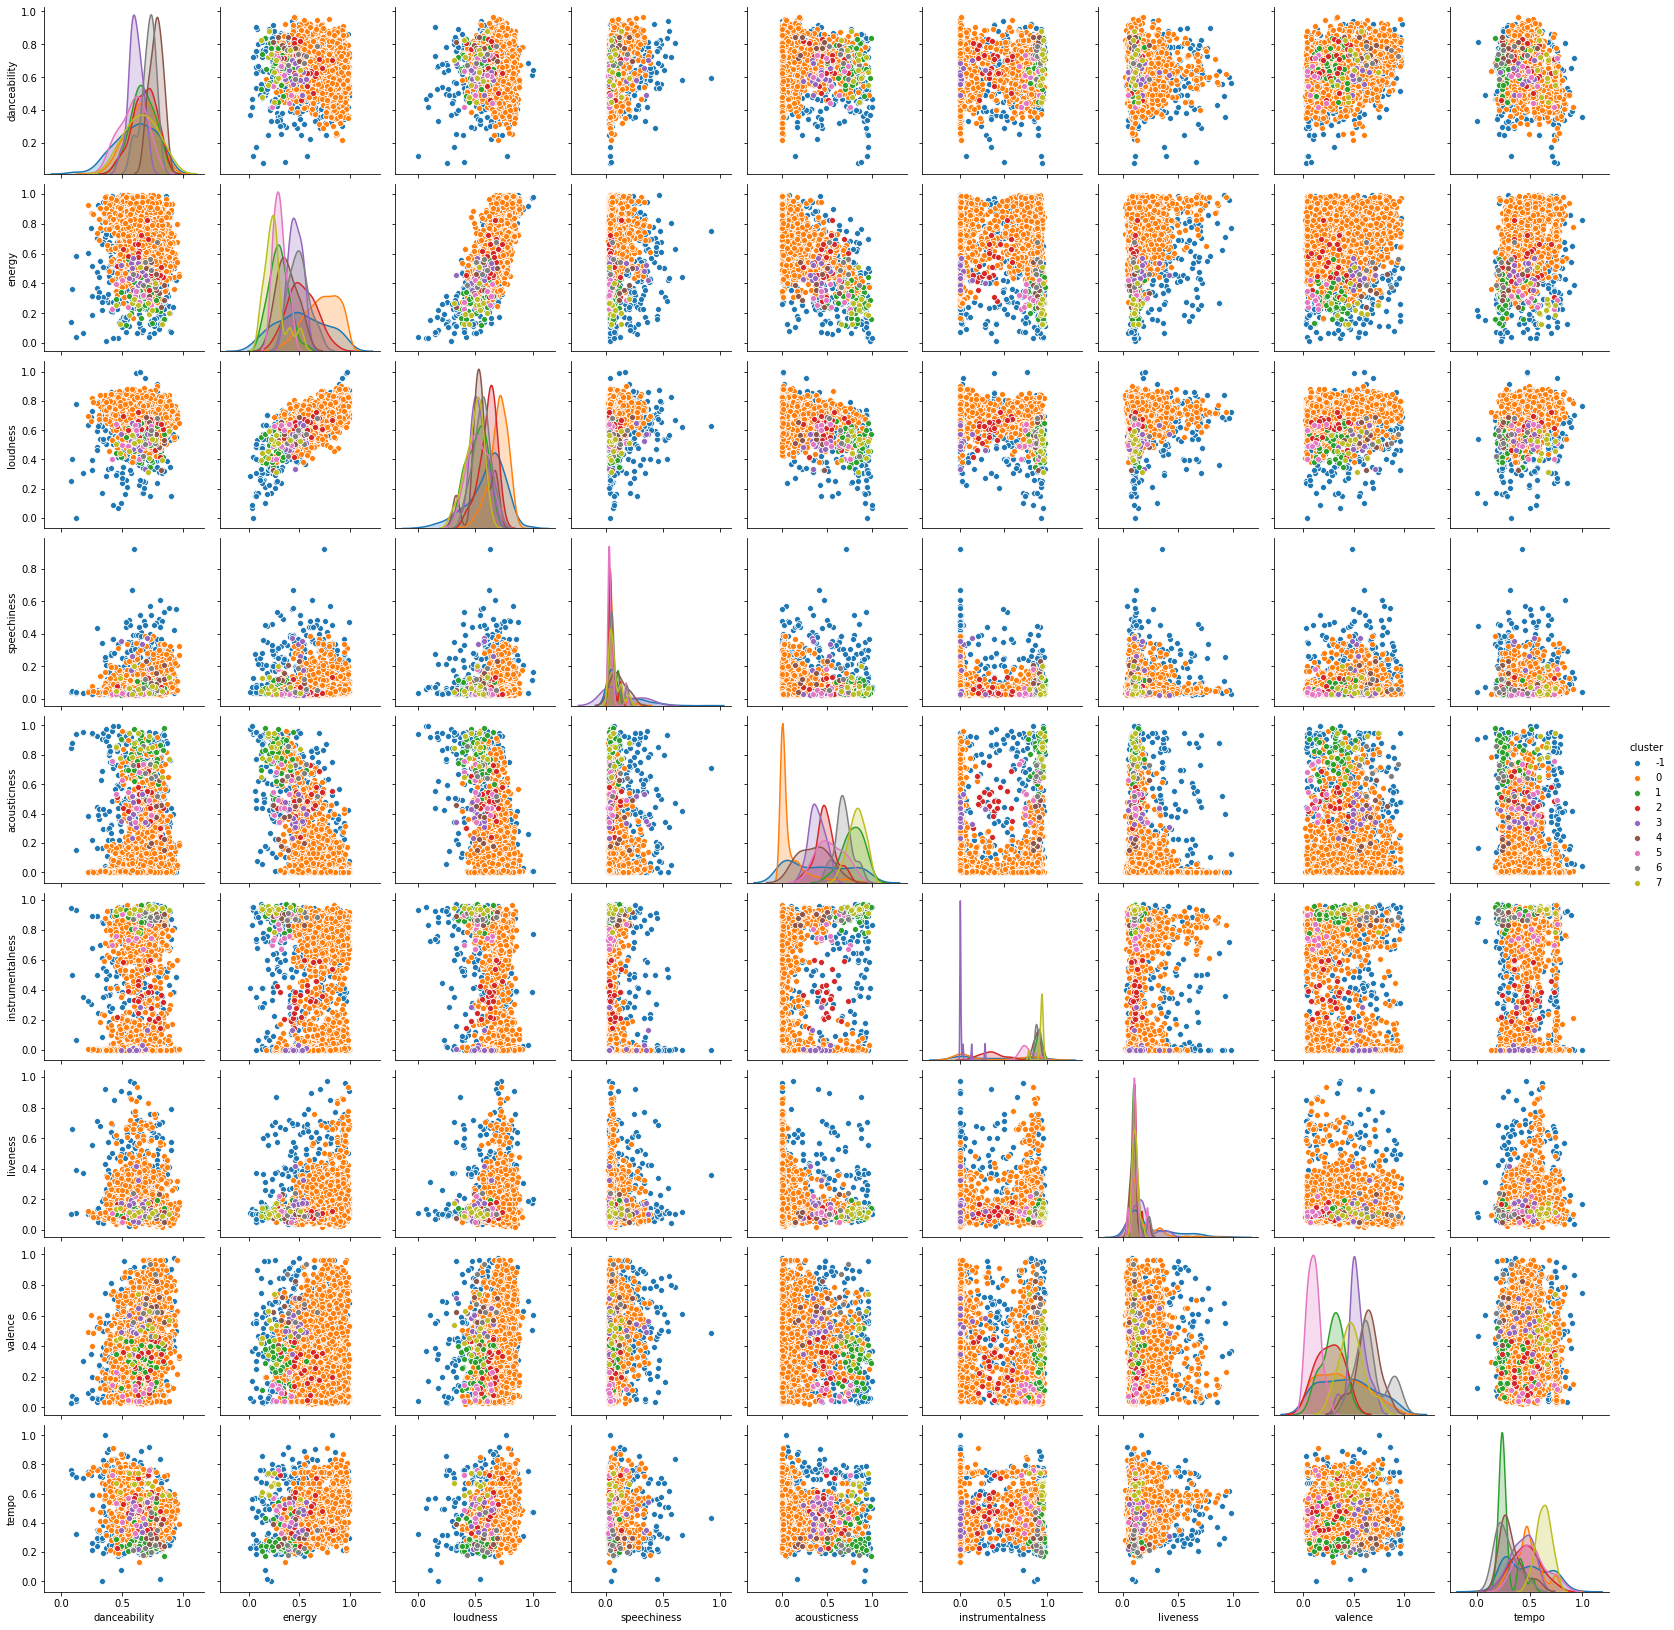

In [62]:
sns.pairplot(tracks_features_per_clustering_date_df,hue='cluster')